In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import os

2.0.0


In [223]:
path = './datasets/brats2015_training_crop_mri.tfrecords'

In [231]:
dataset = tf.data.TFRecordDataset(path, compression_type='GZIP')

#dataset = dataset.shuffle(128, reshuffle_each_iteration=True, seed = 42)

# ABOUT SHUFFLING THE DATASET:

# This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, 
# replacing the selected elements with new elements. 

# For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will 
# initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, 
# its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

# For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
# Buffer size of 128 is not that high. In a window of 16 samples, there are scans belonging only to two patients.
# With a buffer size of 1000, in a window of 16 samples there are scans of 6 patients. Shuffle is not perfect yet.


In [289]:
# DATASET DETAILS: 

# The whole dataset (training + testing + val) has a total of 274 patients with scans of all the 4 modalities
# so 274 * 4 * 128 = 140,288 images.
# (128 because per each modality and each patient, the scan is a volume, so 128 different levels)

# 219 patients for the training: 112,128
# 27 patients for the validation: 13,824
# 28 patients for the testing: 14,336

# Each sample of the dataset, so each tf.record, contains smth around 125 features, a lot of them irrelevant for 
# generation. OT is relative to the ground truth. Features like 'MR_T1_patient' and 'MR_T2_patient' are redundant
# since contain the same value (relative to the same patient!)
# Each sample contains 125 features, as said,and 4 of them are the 4 modalities (MR_T1, MR_T1c, MR_T2, MR_Flair)
# (there is also one more image per sample that is the ground truth - useless for the generation)

# The scans belonging to a sample are 2D slices of the brain.
# Per each patient and per each modality, there are 128 (shape of Z dimension) 2D slices belonging to the 
# same 3D scan.


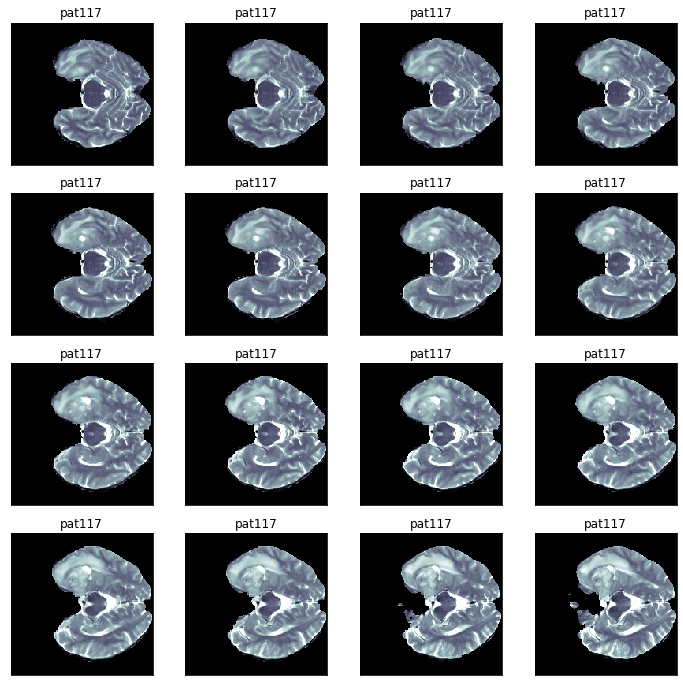

In [315]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (12 , 12))
i = 0
n = 0
size = 40

for raw_record in dataset.take(size):
    #print(dict(example.features.feature).keys())
    #print(dict(example.features.feature).values())
    i += 1 
    if (i >= (size-15)):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        string = example.features.feature['MR_T2_mri'].bytes_list.value[0]
        output = np.frombuffer(string, dtype=np.float32)
        test = np.reshape(output, (180, 180))
        
        n += 1
        plt.subplot(4 , 4 , n)
        plt.imshow(test, cmap='bone')
        a = example.features.feature['MR_T2_patient'].bytes_list.value[0]
        str = a.decode("utf-8") 
        plt.title(str)
        plt.xticks([]) , plt.yticks([])

Patient_code: pat117
Modalities: 


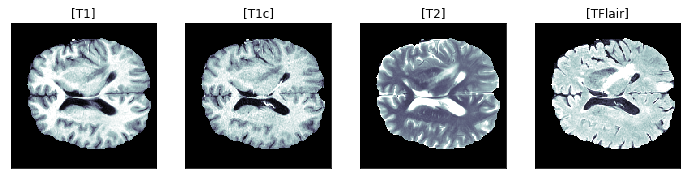

In [317]:
plt.figure(1 , figsize = (12 , 12))
i = 0
n = 0
size = 70

modalities = ['MR_T1_mri', 'MR_T1c_mri', 'MR_T2_mri', 'MR_Flair_mri']

for raw_record in dataset.take(size):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    i += 1
    if i == size:
        patient = example.features.feature['MR_T2_patient'].bytes_list.value[0]
        patient_decoded = patient.decode("utf-8") 
        print("Patient_code: {}".format(patient_decoded))
        print("Modalities: ")
        for idx,mod in enumerate(modalities):
            string = example.features.feature[mod].bytes_list.value[0]
            output = np.frombuffer(string, dtype=np.float32)
            test = np.reshape(output, (180, 180))
            n += 1
            plt.subplot(1 , 4 , n)
            plt.imshow(test, cmap='bone')
            if idx == 0: 
                str = 'T1' 
            elif idx == 1: 
                str = 'T1c' 
            elif idx == 2: 
                str = 'T2'
            elif idx == 3: 
                str = 'TFlair'
            plt.title('[{}]'.format(str))
            plt.xticks([]) , plt.yticks([])

In [442]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:  
        features.update(feature_description(mod))
    return features

In [451]:
use_gzip_compression = True

# with batch size = 32 and 35'072 different samples (each tf.record contains 4 images -> the 4 modalities) 
# we'll have 1096 different batches. 

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=32, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './datasets/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset
    
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    dataset = dataset.cache() if cache else dataset
    
    #print(type(parsed_image_dataset))
    #for image_features in parsed_image_dataset:
    #    image_raw = image_features['image_raw'].numpy()
    #    print("Enter here")
    #    display.display(display.Image(data=image_raw))
    
    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
        
        
    # Number of elements to prefetch should be equal to (or possibly greater than) the number of batches 
    # consumed by a single training step. You could either manually tune this value, or set it to 
    # tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime   
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [493]:
# loading all the dataset, with all the modalities.

validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2', 'MR_T1c', 'MR_Flair'])
training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2', 'MR_T1c', 'MR_Flair'])
testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2', 'MR_T1c', 'MR_Flair'])

In [494]:
# Let's take a look to the validation set
print(type(validation))

for raw_record in validation.take(1):
    print(type(raw_record))

# So now each sample will be a batch of 32 patients ('cause batch_size = 32). 
# Each patient has 4 scans (+1 ground truth)
# So each raw_record than contains 32 complete scans (each scan has 4 modalities)

# In particular, each sample is a dictionary, with all the features as keys. Each value
# belonging to a key has 32 elements !!!! (= batch_size).
# Each value is a numpy array with a shape of (32,)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'dict'>


In [495]:
# DROP ALL THE KEYS (FEATURES) OF THE DICTIONARY BUT THE IMAGES.  
# IS IT NECESSARY ???

for k in list(raw_record.keys()):
    if k != 'MR_T1_mri' and k != 'MR_T2_mri' and k != 'MR_T1c_mri' and k != 'MR_Flair_mri':
        del raw_record[k]

#del validation['MR_Flair_mri_hperc']
raw_record.keys()

dict_keys(['MR_Flair_mri', 'MR_T1_mri', 'MR_T1c_mri', 'MR_T2_mri'])

Modalities: 


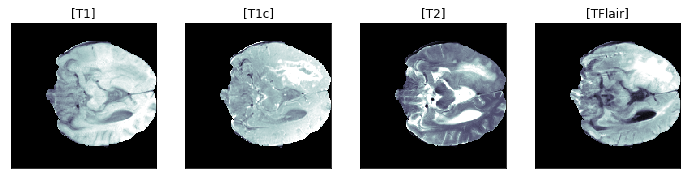

In [430]:
index_batch = 21

plt.figure(1 , figsize = (12 , 12))
n = 0
            
print("Modalities: ")
for idx,mod in enumerate(modalities):
    image = raw_record[mod].numpy()
    output = np.frombuffer(image[index_batch], dtype=np.float32)
    test = np.reshape(output, (180, 180))

    n += 1
    plt.subplot(1 , 4 , n)
    plt.imshow(test, cmap='bone')
    if idx == 0: 
        str = 'T1' 
    elif idx == 1: 
        str = 'T1c' 
    elif idx == 2: 
        str = 'T2'
    elif idx == 3: 
        str = 'TFlair'
    plt.title('[{}]'.format(str))
    plt.xticks([]) , plt.yticks([])